In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from typing import List
import pandas as pd
import seaborn as sns

import nnts
import nnts.data
import nnts.experiments
import nnts.models
import nnts.torch.models
import nnts.metrics
import nnts.torch.data
import nnts.torch.data.datasets
import nnts.loggers
import nnts.torch.models.trainers
import covs 
import nnts.experiments.plotting
import metric_generator


sns.set()

%load_ext autoreload
%autoreload 2

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
def load_metrics(path, name):
    return torch.load(f"{path}/{name}_metrics.pt")

In [3]:
#PATH = f"results/{model_name}/{metadata.dataset}"
ARTICLE_PATH = "/Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures"

In [4]:
def create_scenarios(df_orig: pd.DataFrame, metadata: nnts.data.Metadata, covariates: int):
    ''' create scenarios for a dataset with a given number of covariates'''
    scenario_list: List[nnts.experiments.CovariateScenario] = []
    # Models for full forecast horizon with covariates
    scenario_list.append(
        nnts.experiments.CovariateScenario(metadata.prediction_length, 0, covariates=0),
    )
    for error in covs.errors[metadata.dataset]:
        scenario_list.append(
            nnts.experiments.CovariateScenario(
                metadata.prediction_length, error, covariates=covariates
            )
        )

    scenario_list = covs.prepare_scenarios(df_orig, scenario_list)
    selected_scenarios = scenario_list[:5]
    # selected_scenarios.extend(scenario_list[2::2])
    return selected_scenarios


PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=0.9711789320755235, pvalue=0.0)
PearsonRResult(statistic=0.897490140605388, pvalue=0.0)
PearsonRResult(statistic=0.8046286874885136, pvalue=0.0)
PearsonRResult(statistic=0.7124083761875727, pvalue=0.0)
PearsonRResult(statistic=0.6299873525946118, pvalue=0.0)
PearsonRResult(statistic=0.5596056571381314, pvalue=0.0)
PearsonRResult(statistic=0.5004929023788671, pvalue=0.0)


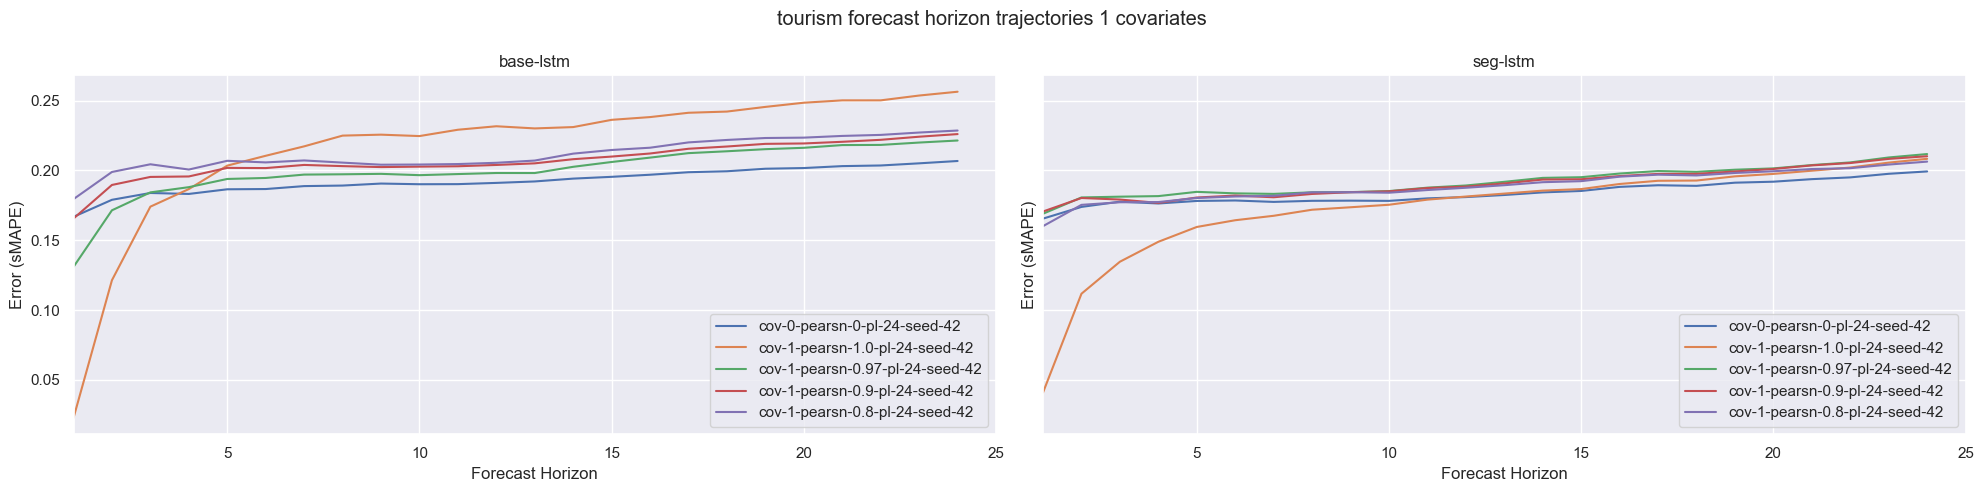

In [42]:
# plot model vs model comparison of smape as a function forecast horizon by PCC with covariates fixed
df_orig, metadata = nnts.data.load("tourism")
covariates = 1
selected_scenarios = create_scenarios(df_orig, metadata, covariates)
plt = nnts.experiments.plotting.plot_forecast_horizon_trajectories(
    selected_scenarios,
    metadata.dataset,
    covariates,
    ["base-lstm", "seg-lstm"],
    loader_fn=load_metrics
)
plt.show()

PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)


<module 'matplotlib.pyplot' from '/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

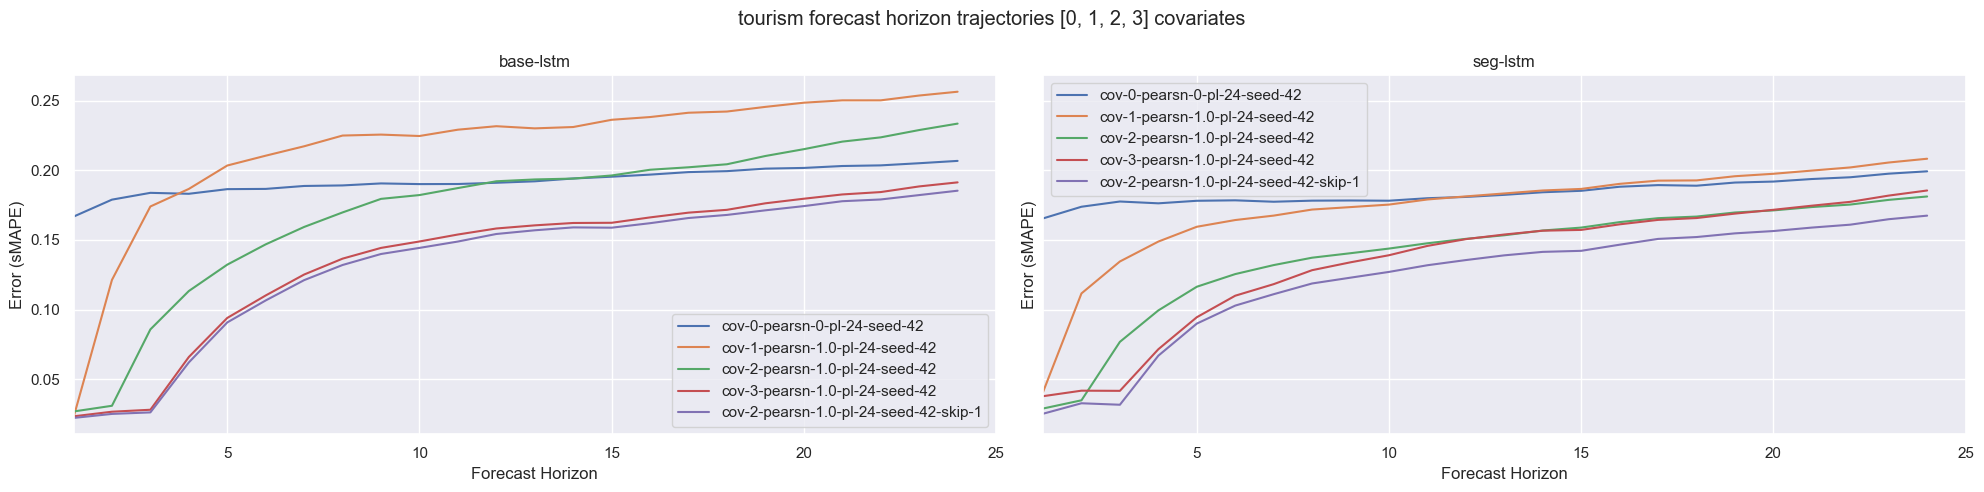

In [40]:
# plot model vs model comparison of smape as a function forecast horizon by covariates with PCC fixed
df_orig, metadata = nnts.data.load("tourism")
scenario_list: List[nnts.experiments.CovariateScenario] = []
covariate_list = [0, 1, 2, 3]
for covariates in covariate_list:
    scenario_list.append(
        nnts.experiments.CovariateScenario(
            metadata.prediction_length, covs.errors[metadata.dataset][0], covariates=covariates
        )
    )
scenario_list.append(
    nnts.experiments.CovariateScenario(
        metadata.prediction_length, 0, covariates=3, skip=1
    ),
)
scenario_list = covs.prepare_scenarios(df_orig, scenario_list)

# covariates = 1
# selected_scenarios = create_scenarios(df_orig, metadata, covariates)
nnts.experiments.plotting.plot_forecast_horizon_trajectories(
    scenario_list, metadata.dataset, covariate_list, ["base-lstm", "seg-lstm"], loader_fn=load_metrics
)

In [10]:
#model_name = "seg-lstm"
#scenario_covariate = 3
dataset_list = ["hospital", "tourism", "traffic"]

for model_name in ["base-lstm", "seg-lstm"]:
    for scenario_covariate in [1,2,3]:
        fig = covs.plot_pcc_charts(
            model_name, scenario_covariate, dataset_list, path=ARTICLE_PATH
        )

PearsonRResult(statistic=0.9999999999999897, pvalue=0.0)
PearsonRResult(statistic=0.972361304216088, pvalue=0.0)
PearsonRResult(statistic=0.9007437413868611, pvalue=0.0)
PearsonRResult(statistic=0.8091056600204567, pvalue=0.0)
PearsonRResult(statistic=0.7169175903531867, pvalue=0.0)
PearsonRResult(statistic=0.6337362642077184, pvalue=0.0)
PearsonRResult(statistic=0.5622351902559289, pvalue=0.0)
PearsonRResult(statistic=0.5019143381047337, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=0.9711789320755235, pvalue=0.0)
PearsonRResult(statistic=0.897490140605388, pvalue=0.0)
PearsonRResult(statistic=0.8046286874885136, pvalue=0.0)
PearsonRResult(statistic=0.7124083761875727, pvalue=0.0)
PearsonRResult(statistic=0.6299873525946118, pvalue=0.0)
PearsonRResult(statistic=0.5596056571381314, pvalue=0.0)
PearsonRResult(statistic=0.5004929023788671, pvalue=0.0)
PearsonRResult(statistic=0.9999999999999614, pvalue=0.0)
PearsonRResult(statistic=0.9735125918751357, pva

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/seg-lstm_k_2_smape_vs_pearson.png
PearsonRResult(statistic=0.9999999999999897, pvalue=0.0)
PearsonRResult(statistic=0.972361304216088, pvalue=0.0)
PearsonRResult(statistic=0.9007437413868611, pvalue=0.0)
PearsonRResult(statistic=0.8091056600204567, pvalue=0.0)
PearsonRResult(statistic=0.7169175903531867, pvalue=0.0)
PearsonRResult(statistic=0.6337362642077184, pvalue=0.0)
PearsonRResult(statistic=0.5622351902559289, pvalue=0.0)
PearsonRResult(statistic=0.5019143381047337, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=0.9711789320755235, pvalue=0.0)
PearsonRResult(statistic=0.897490140605388, pvalue=0.0)
PearsonRResult(statistic=0.8046286874885136, pvalue=0.0)
PearsonRResult(statistic=0.7124083761875727, pvalue=0.0)
PearsonRResult(statistic=0.6299873525946118, pvalue=0.0)
PearsonRResult(statistic=0.5596056571381314, pvalue=0.0)
PearsonRResult(statistic=0.500492902378

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/seg-lstm_k_3_smape_vs_pearson.png


In [12]:
fig.savefig(f"results/{model_name}/{model_name}_smape_vs_pearson.png")
fig.savefig(f"{ARTICLE_PATH}/{model_name}_smape_vs_pearson.png")

<Figure size 640x480 with 0 Axes>

In [13]:
fig.show()

In [39]:
# Generate data for analysis - required once only after model training
model_name = "base-lstm"
df_orig, metadata = nnts.data.load("tourism")

if model_name == "seg-lstm":
    metadata.context_length = (
        metadata.prediction_length * 8 + 1
        if metadata.dataset == "traffic"
        else metadata.prediction_length * 3 + 1
    )
    metadata.seasonality = 8 if metadata.dataset == "traffic" else metadata.seasonality
params = nnts.models.Hyperparams()

scenario_list: List[nnts.experiments.CovariateScenario] = []
# Add the baseline scenarios
scenario_list.append(
    nnts.experiments.CovariateScenario(
        metadata.prediction_length, error=0.0, covariates=0
    )
)
# Models for full forecast horizon with covariates
for covariates in [1, 2, 3]:
    for error in covs.errors[metadata.dataset]:
        scenario_list.append(
            nnts.experiments.CovariateScenario(
                metadata.prediction_length, error, covariates=covariates
            )
        )
scenario_list.append(
    nnts.experiments.CovariateScenario(
        metadata.prediction_length, 0, covariates=3, skip=1
    )
)
metric_generator.generate(scenario_list, df_orig, metadata, params, model_name)

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=1.0, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.9711789320755235, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.897490140605388, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.8046286874885136, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.7124083761875727, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.6299873525946118, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.5596056571381314, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.5004929023788671, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=1.0, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.9711789320755235, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.897490140605388, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.8046286874885136, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.7124083761875727, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.6299873525946118, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.5596056571381314, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.5004929023788671, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=1.0, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.9711789320755235, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.897490140605388, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.8046286874885136, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.7124083761875727, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.6299873525946118, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.5596056571381314, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=0.5004929023788671, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


PearsonRResult(statistic=1.0, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [36]:
dataset = "traffic"
model_name = "base-lstm"
csv_aggregator = covs.CSVFileAggregator(f'results/{model_name}/{dataset}', "results")
results = csv_aggregator()

In [37]:

df_orig, metadata = nnts.data.load(dataset)

In [38]:
results.loc[
    (results["covariates"] == 0)
    & (results["prediction_length"] == metadata.prediction_length),
    ["smape", "mae", "rmse"],
].mean()

smape    0.127690
mae      1.151312
rmse     1.559358
dtype: float64

/Users/garethdavies/Development/workspaces/nnts/projects/covariates/covs.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/Users/garethdavies/Development/workspaces/nnts/projects/covariates/covs.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/Users/garethdavies/Development/workspaces/nnts/projects/covariates/covs.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

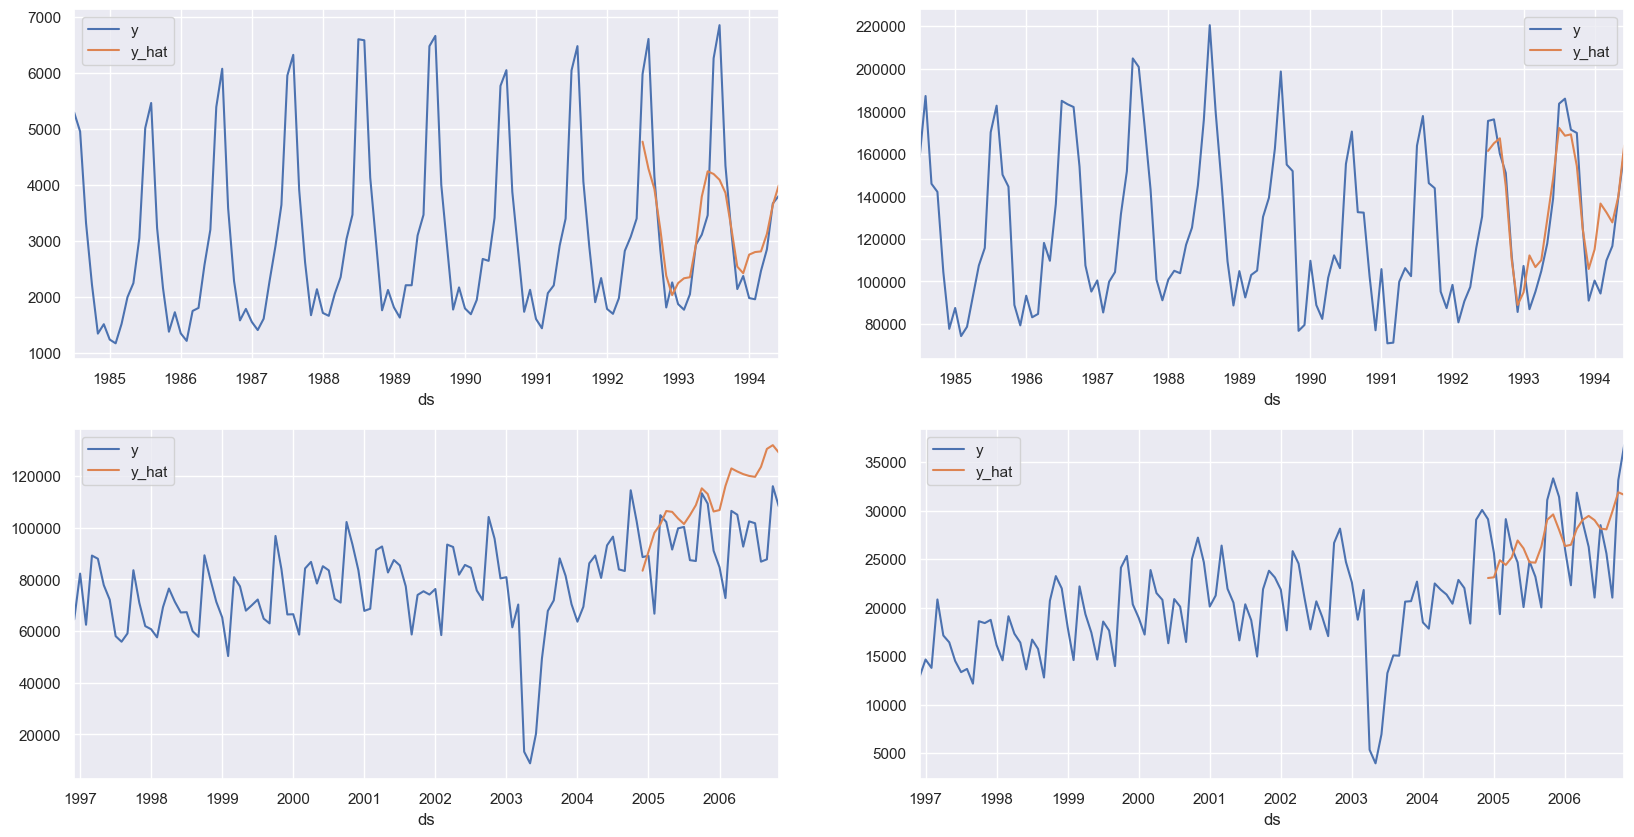

In [135]:
df_list = covs.add_y_hat(df, y_hat, scenario.prediction_length)
sample_preds = covs.plot(df_list, scenario.prediction_length)

smape      0.212022
mape            inf
rmse     469.076904
mae      287.952765
dtype: float64